In [ ]:
import pandas as pd
import numpy as np
import joblib
import h5py
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gl= pd.read_csv(
    '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/gl.csv')

In [ ]:
gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   발생시각           524 non-null    object 
 1   규모             524 non-null    float64
 2   깊이(km)         476 non-null    float64
 3   위도             524 non-null    float64
 4   경도             524 non-null    float64
 5   발생일            524 non-null    object 
 6   p_arrival_utc  476 non-null    object 
 7   s_arrival_utc  476 non-null    object 
dtypes: float64(4), object(4)
memory usage: 32.9+ KB


In [ ]:
# 1. 설정
RAW_H5_PATH = '/content/drive/MyDrive/TriAI/Data/포항_201711_전처리완료/merged_seismic_data.h5'
SAVE_PATH = '/content/drive/MyDrive/TriAI/Data/포항_201711_전처리완료/EQT_Multitask_Dataset.h5'

SAMPLING_RATE = 100.0
WINDOW_LEN = 6000
CENTER_OFFSET = 3000
START_TIME_UTC = pd.Timestamp("2017-10-31 15:00:00.008392", tz="UTC")

# 노이즈 데이터 생성 개수
NOISE_SAMPLES = 400

In [ ]:
gl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   발생시각           524 non-null    object 
 1   규모             524 non-null    float64
 2   깊이(km)         476 non-null    float64
 3   위도             524 non-null    float64
 4   경도             524 non-null    float64
 5   발생일            524 non-null    object 
 6   p_arrival_utc  476 non-null    object 
 7   s_arrival_utc  476 non-null    object 
dtypes: float64(4), object(4)
memory usage: 32.9+ KB


In [ ]:
# 2. 데이터셋 생성 함수
if os.path.exists(SAVE_PATH):
    os.remove(SAVE_PATH)

print("데이터셋 재생성: 지진 + 노이즈 + 규모")

gl['p_arrival_utc'] = pd.to_datetime(gl['p_arrival_utc'])
gl['s_arrival_utc'] = pd.to_datetime(gl['s_arrival_utc'])

valid_events = gl.dropna(subset=['p_arrival_utc', 's_arrival_utc'])
earthquake_times = []

try:
    with h5py.File(RAW_H5_PATH, 'r') as f_raw, h5py.File(SAVE_PATH, 'w') as f_train:
        raw_data = f_raw['data']
        total_samples = raw_data.shape[0]

        # 저장할 데이터셋 (X: 파형, y_class: 발생여부, y_mag: 규모)
        dset_X = f_train.create_dataset('X', shape=(0, 6000, 3), maxshape=(None, 6000, 3), dtype='float32')
        dset_y_class = f_train.create_dataset('y_class', shape=(0, 1), maxshape=(None, 1), dtype='float32')
        dset_y_mag = f_train.create_dataset('y_mag', shape=(0, 1), maxshape=(None, 1), dtype='float32')

        count = 0

        # 1. 지진 데이터 저장
        for idx, row in valid_events.iterrows():
            p_time = row['p_arrival_utc']
            magnitude = row['규모']

            elapsed = (p_time - START_TIME_UTC).total_seconds()
            if elapsed < 0: continue

            p_global = int(elapsed * SAMPLING_RATE)
            earthquake_times.append(p_global)

            start_idx = p_global - CENTER_OFFSET
            end_idx = start_idx + WINDOW_LEN

            if start_idx < 0 or end_idx > total_samples: continue

            # 파형 로드, 정규화
            x_win = raw_data[start_idx : end_idx]
            if np.max(np.abs(x_win)) > 0: x_win /= np.max(np.abs(x_win))

            # 저장
            n = dset_X.shape[0]
            dset_X.resize(n+1, axis=0); dset_X[n] = x_win
            dset_y_class.resize(n+1, axis=0); dset_y_class[n] = 1.0
            dset_y_mag.resize(n+1, axis=0); dset_y_mag[n] = magnitude

            count += 1

        print(f"지진 데이터 {count}개 저장 완료.")

        # 2. 노이즈 데이터 생성
        noise_count = 0
        while noise_count < NOISE_SAMPLES:
            rand_idx = random.randint(0, total_samples - WINDOW_LEN)

            # 지진 발생 구간과 겹치는지 확인 => 겹치면 skip!
            is_overlap = False
            for eq_idx in earthquake_times:
                if abs(rand_idx + CENTER_OFFSET - eq_idx) < WINDOW_LEN:
                    is_overlap = True
                    break
            if is_overlap: continue

            # 파형 로드, 정규화
            x_win = raw_data[rand_idx : rand_idx + WINDOW_LEN]
            if np.max(np.abs(x_win)) > 0: x_win /= np.max(np.abs(x_win))

            # 저장
            n = dset_X.shape[0]
            dset_X.resize(n+1, axis=0); dset_X[n] = x_win
            dset_y_class.resize(n+1, axis=0); dset_y_class[n] = 0.0
            dset_y_mag.resize(n+1, axis=0); dset_y_mag[n] = 0.0

            noise_count += 1

        print(f"노이즈 데이터 {noise_count}개 저장 완료.")
        print(f"총 데이터셋 크기: {dset_X.shape[0]}개")

except Exception as e:
    print(f"에러 발생: {e}")

🔄 데이터셋 재생성 시작 (지진 + 노이즈 + 규모)...
에러 발생: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/TriAI/Data/포항_201711_전처리완료/merged_seismic_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


데이터 로드 완료: X (817, 6000, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6000, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 6000, 8)   │        272 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 3000, 8)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 3000, 16)  │      1,168 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 1500, 16)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1500, 32)  │      3,616 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 750, 32)   │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 750, 32)   │         64 │ max_pooling1d_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 750, 32)   │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 750, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 750, 32)   │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │         17 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │         17 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,074 (90.13 KB)

 Trainable params: 23,074 (90.13 KB)

 Non-trainable params: 0 (0.00 B)


모델 학습 시작...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 420ms/step - classification_accuracy: 0.6677 - classification_loss: 0.5832 - loss: 1.3645 - regression_loss: 0.7796 - regression_mae: 0.6503 - val_classification_accuracy: 0.9817 - val_classification_loss: 0.1454 - val_loss: 0.2836 - val_regression_loss: 0.1310 - val_regression_mae: 0.2337
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - classification_accuracy: 0.9848 - classification_loss: 0.1557 - loss: 0.4663 - regression_loss: 0.3099 - regression_mae: 0.3881 - val_classification_accuracy: 0.9878 - val_classification_loss: 0.0663 - val_loss: 0.2003 - val_regression_loss: 0.1295 - val_regression_mae: 0.2099
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - classification_accuracy: 0.9915 - classification_loss: 0.0757 - loss: 0.2999 - regression_loss: 0.2255 - regression_mae: 0.3276 - val_classification_accuracy: 0.9817 - val_classification_loss: 0.0579 - val_loss: 0.1814 - val_regression_loss: 0.1200 - val_regression_mae:

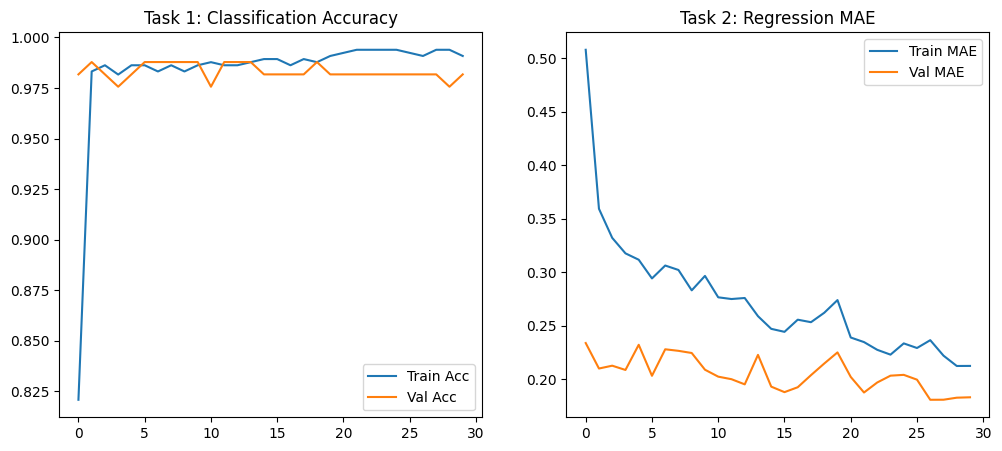

In [ ]:
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

# 1. 데이터 로드
LOAD_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/EQT_Multitask_Dataset_1.h5'

with h5py.File(LOAD_PATH, 'r') as f:
    X_all = f['X'][:]
    y_class_all = f['y_class'][:]
    y_mag_all = f['y_mag'][:]

print(f"데이터 로드 완료: X {X_all.shape}")

# 2. Train/Test 분리
indices = np.arange(len(X_all))
np.random.shuffle(indices)

split_idx = int(len(X_all) * 0.8)
train_idx, test_idx = indices[:split_idx], indices[split_idx:]

X_train, X_test = X_all[train_idx], X_all[test_idx]
y_c_train, y_c_test = y_class_all[train_idx], y_class_all[test_idx]
y_m_train, y_m_test = y_mag_all[train_idx], y_mag_all[test_idx]

# 3. 모델 정의
def build_eqt_multitask_model(input_shape=(6000, 3)):
    inputs = layers.Input(shape=input_shape)

    # [Encoder] 1D CNN Layers
    x = layers.Conv1D(8, 11, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(16, 9, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 7, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)

    # [Attention] Transformer Block
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    att_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = layers.Add()([x, att_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # [Global Pooling] 시계열 정보를 하나로 압축
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)

    # [예측1] 지진 발생 여부 (이진 분류)
    out_class = layers.Dense(16, activation='relu')(x)
    out_class = layers.Dense(1, activation='sigmoid', name='classification')(out_class)

    # [예측2] 지진 규모 예측 (회귀)
    out_mag = layers.Dense(16, activation='relu')(x)
    out_mag = layers.Dense(1, activation='linear', name='regression')(out_mag)

    model = models.Model(inputs=inputs, outputs=[out_class, out_mag])
    return model

# 4. 모델 컴파일
model = build_eqt_multitask_model()
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss={
        'classification': 'binary_crossentropy',
        'regression': 'mse'
    },
    loss_weights={
        'classification': 1.0,
        'regression': 1.0
    },
    metrics={
        'classification': 'accuracy',
        'regression': 'mae'
    }
)

model.summary()

# 5. 학습 시작
print("\n모델 학습 시작...")
history = model.fit(
    X_train, [y_c_train, y_m_train],
    validation_data=(X_test, [y_c_test, y_m_test]),
    epochs=30,
    batch_size=32,
    verbose=1
)

# 6. 평가 및 결과 시각화
print("\n=== 최종 평가 ===")
preds = model.predict(X_test)
pred_class = (preds[0] > 0.5).astype(int)
pred_mag = preds[1]

acc = accuracy_score(y_c_test, pred_class)
mse = mean_squared_error(y_m_test, pred_mag)

print(f"Classification Accuracy: {acc*100:.2f}%")
print(f"Regression MSE: {mse:.4f}")

# 그래프 그리기
plt.figure(figsize=(12, 5))

# 분류 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_accuracy'], label='Train Acc')
plt.plot(history.history['val_classification_accuracy'], label='Val Acc')
plt.title('Task 1: Classification Accuracy')
plt.legend()

# 회귀 오차 (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['regression_mae'], label='Train MAE')
plt.plot(history.history['val_regression_mae'], label='Val MAE')
plt.title('Task 2: Regression MAE')
plt.legend()

plt.show()

In [ ]:
import os

RAW_H5_PATH = '/content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/merged_seismic_data.h5'

if os.path.exists(RAW_H5_PATH):
    print(f"파일이 존재합니다: {RAW_H5_PATH}")
else:
    print(f"파일을 찾을 수 없습니다: {RAW_H5_PATH}")

파일이 존재합니다: /content/drive/MyDrive/TriAI/Data/포항_2017_전처리완료/merged_seismic_data.h5
